In [1]:
import os
import numpy as np
import cv2
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import pandas as pd
from torch.utils.data import DataLoader, Dataset
import time
from glob import glob
import re
from matplotlib import pyplot as plt
from PIL import Image
%matplotlib inline

os.environ["CUDA_VISIBLE_DEVICES"]='2' 


# CNN

## data

In [2]:
def get_paths_and_labels(img_type='training', isLbael=True):
    base_dir = './datasets'
    paths = sorted(glob(os.path.join(base_dir, img_type, '*')))[:]
    
    if isLbael==True: 
        Y = [int(re.search('/(.{1,2})_', path).group(1)) for path in paths]
        return paths, Y
    else:
        return paths
    
x_train_paths, y_train = get_paths_and_labels(img_type='training', isLbael=True)
x_valid_paths, y_valid = get_paths_and_labels(img_type='validation', isLbael=True)
x_test_paths = get_paths_and_labels(img_type='testing', isLbael=False)

len(x_train_paths), len(y_train), len(x_valid_paths), len(y_valid), len(x_test_paths)


(9866, 9866, 3430, 3430, 3347)

In [3]:
# https://discuss.pytorch.org/t/bugs-with-torchvision-transforms-topilimage/26109/2

train_transform = transforms.Compose([
#     transforms.ToPILImage(), # input array, # 轉成PILImage再轉回tensor, 畫圖顏色會跑掉
    transforms.Resize(size=(128, 128)),
    transforms.RandomHorizontalFlip(), 
    transforms.RandomRotation(15), 
    transforms.ToTensor(), 
])

test_transform = transforms.Compose([
#     transforms.ToPILImage(),        
    transforms.Resize(size=(128, 128)),
    transforms.ToTensor(),
])

In [4]:
# Image.open(x_train_paths[10]) # 114ms
# cv2.imread(x_train_paths[10]) # 20ms

In [5]:
class ImgDataset(Dataset):
    def __init__(self, img_paths, labels=None, transform=None):
        self.img_paths = img_paths
        
        self.labels = labels
        if self.labels != None:
            self.labels = torch.LongTensor(labels) ###
            
        self.transform = transform
        
    def __len__(self):
        return len(self.img_paths)
    
    def getbatch(self, indices):
        images = []
        labels = []
        for index in indices:
            image, label = self.__getitem__(index)
            images.append(image)
            labels.append(label)
        return torch.stack(images), torch.tensor(labels)
    
    def __getitem__(self, index):
        img_path = self.img_paths[index]
        img = Image.open(img_path) # read slower
#         img = cv2.imread(img_path) # read faster, but need to be transformed to pilimage, 畫圖顏色會跑掉
#         img = cv2.resize(img, (128, 128))
        
        if self.transform!=None: img = self.transform(img)
            
        if self.labels==None: 
            return img
        else:
            label = self.labels[index]
            return img, label
        

train_set = ImgDataset(x_train_paths, y_train, train_transform)
valid_set = ImgDataset(x_valid_paths, y_valid, test_transform)
test_set = ImgDataset(x_test_paths, None, test_transform)


In [6]:
# valid_set[10], len(valid_set)

In [7]:
batch_size = 50
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True) 
valid_loader = DataLoader(valid_set, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

## model

In [8]:
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        # torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)
        # torch.nn.MaxPool2d(kernel_size, stride, padding)
        # input 維度 [3, 128, 128]
        self.cnn = nn.Sequential(
            nn.Conv2d(3, 64, 3, 1, 1),  # [64, 128, 128]
            nn.BatchNorm2d(num_features=64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),      # [64, 64, 64]

            nn.Conv2d(64, 128, 3, 1, 1), # [128, 64, 64]
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),      # [128, 32, 32]

            nn.Conv2d(128, 256, 3, 1, 1), # [256, 32, 32]
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),      # [256, 16, 16]

            nn.Conv2d(256, 512, 3, 1, 1), # [512, 16, 16]
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),       # [512, 8, 8]
            
            nn.Conv2d(512, 512, 3, 1, 1), # [512, 8, 8]
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0),       # [512, 4, 4]
        )
        
        self.fc = nn.Sequential(
            nn.Linear(512*4*4, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 11)
        )

    def forward(self, in_):
        x = self.cnn(in_)
        x = x.reshape(x.shape[0], -1) # x.shape = x.sise()
        out_ = self.fc(x)
        return out_

## train

In [9]:
# history
df_history = pd.DataFrame({'epoch':[0],'time':[0],'train_loss':[float('inf')],'train_acc':[0],'valid_loss':[float('inf')],'valid_acc':[0]})

# early stop
monitor = 'valid_acc'
min_delta = 0.01
patience = 10
best_monitor = df_history.loc[0,monitor]


In [10]:
# model_cnn = Classifier().cuda()
# epochs = 100

# loss_fn = nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(params=model_cnn.parameters(), lr=0.001)

# for epoch in range(epochs):
#     print('-'*80)
#     epoch_start_time = time.time()
#     train_acc = 0.
#     valid_acc = 0.
#     train_loss = 0.
#     valid_loss = 0.
    
#     # ----------------------------------------------
#     #  train 
#     # ----------------------------------------------
#     model_cnn.train() ###
#     for (i, data) in enumerate(train_loader):
#         x, y = data[0].cuda(), data[1].cuda()
        
#         optimizer.zero_grad()
#         y_hat = model_cnn(x)
#         batch_loss = loss_fn(y_hat, y)
#         batch_loss.backward()
#         optimizer.step()
        
#         label_hat = np.argmax(y_hat.cpu().data.numpy(), axis=1)
#         label = y.cpu().data.numpy()
#         match = (label_hat==label)
#         train_acc += sum(match)
#         train_loss += batch_loss.item()
        
#     # ----------------------------------------------
#     #  valid 
#     # ----------------------------------------------
#     model_cnn.eval() 
#     with torch.no_grad(): 
#         for (i, data) in enumerate(valid_loader):
#             x, y = data[0].cuda(), data[1].cuda()
#             y_hat = model_cnn(x)
#             batch_loss = loss_fn(y_hat, y)
            
#             label_hat = np.argmax(y_hat.cpu().data.numpy(), axis=1)
#             label = y.cpu().data.numpy()
#             match = (label_hat==label)
#             valid_acc += sum(match)
#             valid_loss += batch_loss.item()
    
#     # ----------------------------------------------
#     #  progress bar 
#     # ----------------------------------------------
#     epoch += 1
#     t = time.time() - epoch_start_time
#     train_loss /= len(train_set)
#     valid_loss /= len(valid_set)
#     train_acc /= len(train_set)
#     valid_acc /= len(valid_set)

#     print('epoch = %d, time = %d, train_loss = %.3f, train_acc = %.2f, valid_loss = %.3f, valid_acc = %.2f'%(
#         epoch, t, train_loss, train_acc, valid_loss, valid_acc))
    
    
#     # history
#     df_history_epoch = pd.DataFrame({'epoch':[epoch],'time':[t],'train_loss':[train_loss],'train_acc':[train_acc],'valid_loss':[valid_loss],'valid_acc':[valid_acc]})
#     df_history = df_history.append(df_history_epoch)
    
#     # checkpointer
#     monitor_list = df_history[monitor].tolist()
#     cur_monitor = monitor_list[-1]
#     if cur_monitor-best_monitor > min_delta:
#         torch.save(model_cnn.state_dict(), './best_model_cnn.pt')
#         print('%s improve from %.4f to %.4f, saving model_cnn'%(monitor, best_monitor, cur_monitor))
        
#         best_monitor = cur_monitor
#         i_best_monitor = epoch
    
#     # earlystop
#     i_cur_monitor = epoch
#     if (i_cur_monitor-i_best_monitor) > patience: 
#         print('#'*80)
#         print('early stop')
#         print('best %s = %.4f'%(monitor, best_monitor))
#         break

In [11]:
# df_history = df_history.reset_index(drop=True)
# df_history.to_csv('./df_history.csv',index=False)


In [12]:
df_history = pd.read_csv('./df_history.csv')

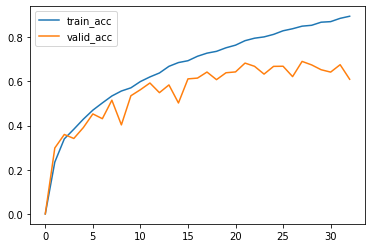

In [13]:
df_history.plot(y=['train_acc','valid_acc'])

# saliency map

- https://discuss.pytorch.org/t/difference-between-2-reshaping-operations-reshape-vs-permute/30749/7

- tensor.permute, nparray.transpose

In [14]:
best_model_cnn = Classifier().cuda()
best_model_cnn.load_state_dict(torch.load('./best_model_cnn.pt'))

<All keys matched successfully>

In [15]:
import random
idxs = random.sample(range(len(train_set)), 4)
# idxs = [83, 4218, 4707, 8598]
idxs

[3560, 7841, 8007, 692]

In [16]:
data = [train_set.__getitem__(idx) for idx in idxs]
imgs = torch.stack([x[0] for x in data])
labels = torch.stack([x[1] for x in data])

imgs.shape, labels.shape

(torch.Size([4, 3, 128, 128]), torch.Size([4]))

In [17]:
def get_saliency_maps(x, y, model):
    loss_fn = torch.nn.CrossEntropyLoss()
    # eval
    model.eval()
    
    # move to gpu
    x = x.cuda()
    y = y.cuda()
    
    # x require grad 
    x.requires_grad_()
    
    # y_hat
    y_hat = model(x)
    
    # calculate loss
    loss = loss_fn(y_hat, y)
    
    # calculate gradient
    loss.backward()
    
    # get x.grad
    saliency_maps = x.grad.abs().detach().cpu()
    return saliency_maps

smaps = get_saliency_maps(imgs, labels, best_model_cnn)
smaps.shape

torch.Size([4, 3, 128, 128])

In [18]:
def normalize_img(smap):
    eps = 1e-16
    min_ = smap.min() # sclar
    max_ = smap.max()
    smap = (smap - min_) / (max_ - min_ + eps)
    return smap

# np.min(saliency_map, axis=None)

smaps_norm = torch.stack([normalize_img(smap) for smap in smaps])
smaps_norm.shape

torch.Size([4, 3, 128, 128])

In [19]:
imgs.device, smaps_norm.device

(device(type='cpu'), device(type='cpu'))

In [20]:
img_matrix = [[x.permute(1,2,0) for x in imgs],
              [x.permute(1,2,0) for x in smaps_norm]]

nrows = len(img_matrix)
ncols = len(img_matrix[0])

print(nrows, ncols)
print(img_matrix[0][0].shape)

2 4
torch.Size([128, 128, 3])


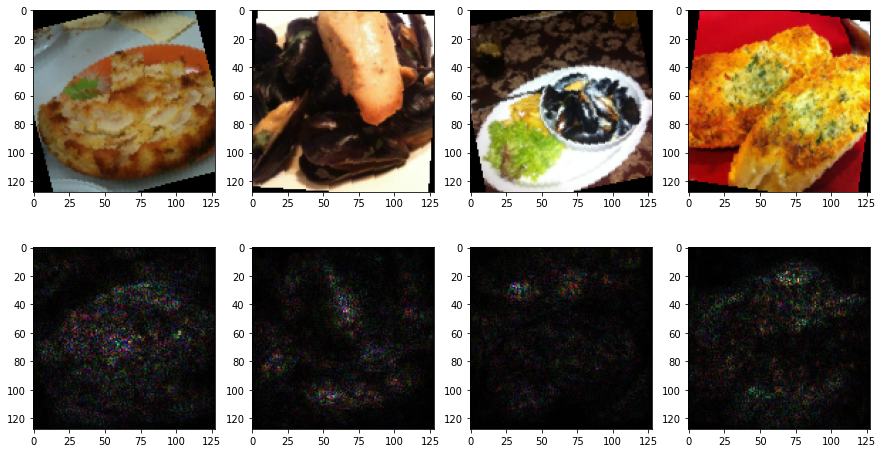

In [21]:
fig, axs = plt.subplots(nrows, ncols, figsize=(15, 8))
for row in range(nrows):
    for col in range(ncols):
        ax = axs[row, col]
        img_ = img_matrix[row][col]
        ax.imshow(img_)
        
plt.show()

# test

# filter visualization
- https://zhuanlan.zhihu.com/p/75054200
- https://discuss.pytorch.org/t/register-forward-hook-function-usage/28062/11

## which img activates the filter most

In [215]:
# best_model_cnn.cnn

In [261]:
cnnid = 4
filterid = 25
best_model_cnn.cnn[cnnid]

Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))

In [262]:
shape = (1, 3, 128, 128)
x = torch.rand(shape)
x.shape

torch.Size([1, 3, 128, 128])

In [263]:
layer_output = None
def hook(model, input, output):
    global layer_output
    layer_output = output

In [264]:
hook_handle = best_model_cnn.cnn[cnnid].register_forward_hook(hook)


In [265]:
x = x.cuda()
x.requires_grad_()
optimizer = torch.optim.Adam(params=[x], lr=0.1)

iteration = 100

best_model_cnn.eval()
for i in range(iteration):
    optimizer.zero_grad() # reset_grad
    y_hat = best_model_cnn(x) # forward
    
    output1 = layer_output 
    output2 = output1[:,filterid,:,:]
    print(output2.shape)
    output3 = output2.sum()
    print(output3.shape, output3.data)
    objective = -output3 # maximize output3
    
    objective.backward() # get grad
    optimizer.step() # update x
    


torch.Size([1, 64, 64])
torch.Size([]) tensor(-63028.7852, device='cuda:0')
torch.Size([1, 64, 64])
torch.Size([]) tensor(-37166.3750, device='cuda:0')
torch.Size([1, 64, 64])
torch.Size([]) tensor(-20673.4141, device='cuda:0')
torch.Size([1, 64, 64])
torch.Size([]) tensor(-9366.3340, device='cuda:0')
torch.Size([1, 64, 64])
torch.Size([]) tensor(-987.2750, device='cuda:0')
torch.Size([1, 64, 64])
torch.Size([]) tensor(5991.1558, device='cuda:0')
torch.Size([1, 64, 64])
torch.Size([]) tensor(12364.7588, device='cuda:0')
torch.Size([1, 64, 64])
torch.Size([]) tensor(18285.7539, device='cuda:0')
torch.Size([1, 64, 64])
torch.Size([]) tensor(23908.0430, device='cuda:0')
torch.Size([1, 64, 64])
torch.Size([]) tensor(29333.0352, device='cuda:0')
torch.Size([1, 64, 64])
torch.Size([]) tensor(34709.9883, device='cuda:0')
torch.Size([1, 64, 64])
torch.Size([]) tensor(39956.6445, device='cuda:0')
torch.Size([1, 64, 64])
torch.Size([]) tensor(45161.0625, device='cuda:0')
torch.Size([1, 64, 64])


In [266]:
hook_handle.remove()

In [267]:
x_ = x.detach().cpu()
print(x_.shape)

x_ = x_.squeeze()
print(x_.shape)

x_ = x_.permute(1,2,0)
print(x_.shape)

x_ = normalize_img(x_)
print(x_.shape)

torch.Size([1, 3, 128, 128])
torch.Size([3, 128, 128])
torch.Size([128, 128, 3])
torch.Size([128, 128, 3])


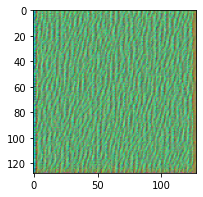

In [268]:
fig, axs = plt.subplots(1, 1, figsize=(16/3, 9/3))
plt.imshow(x_)
plt.show()
plt.close()

In [269]:
# np.array(100).shape, np.array(100)

##  (img, filter) => activation map 

In [270]:
img_indices = [83, 4218, 4707, 8598] # [83, 4218, 4707, 8598] [1000,2000,3000,4000]
data = [train_set[idx] for idx in img_indices] # [train_set.__getitem__(idx) for idx in idxs]
images = torch.stack([x[0] for x in data])
labels = torch.stack([x[1] for x in data])
print(images.shape, labels.shape)

torch.Size([4, 3, 128, 128]) torch.Size([4])


In [271]:
hook_handle = best_model_cnn.cnn[cnnid].register_forward_hook(hook)


In [272]:
x = images.cuda()
x.requires_grad_()
optimizer = torch.optim.Adam(params=[x], lr=0.1)

best_model_cnn.eval()
y_hat = best_model_cnn(x) # forward

output1 = layer_output # cnn output
output2 = output1[:,filterid,:,:] # filter output

activation_maps = output2.detach().cpu()
print(activation_maps.shape)

torch.Size([4, 64, 64])


In [273]:
hook_handle.remove()

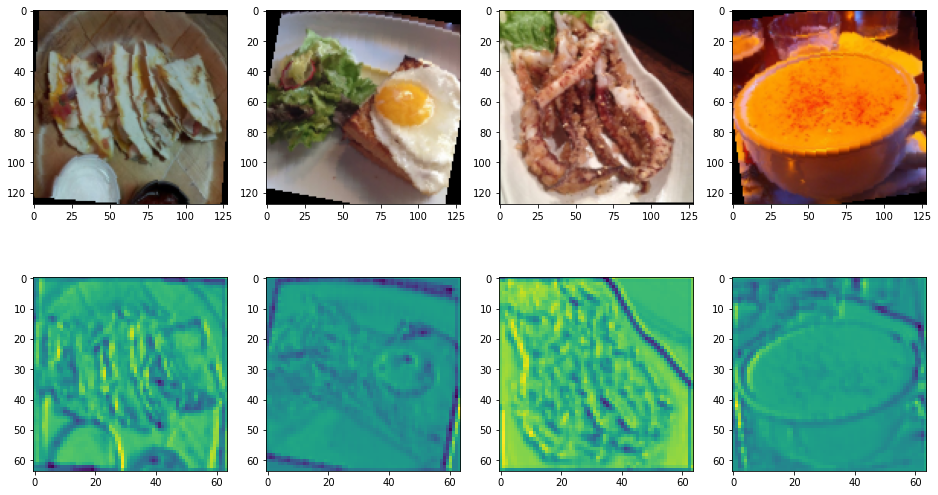

In [274]:
fig, axs = plt.subplots(2, len(images), figsize=(16, 9))

for i, img in enumerate(images):
    img_ = img.permute(1,2,0)
    axs[0,i].imshow(img_)
    
for i, img in enumerate(activation_maps):
    img_ = normalize_img(img)
    axs[1,i].imshow(img_)
    
plt.show()
plt.close()

# lime